In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join as J
import h5py

Генерирует симуляции в исходной карте 400 на 400 на время 1000, все остальные параметры - исходные

In [89]:
nx = 400 # number of grid points in the horizontal direction
nz = 400 # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 1000 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 900 # source horizontal location in meters
srcz = 800 # source vertical location in meters

nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

vp = np.arange(2000,4500,(4500-2000)/nz)
vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model

#vp = np.ones((nx,nz))*3000.0

time = np.arange(0,nt*dt,dt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
wav  = (1.0-2.0*np.power(np.pi*f0*(time-t0),2))*np.exp(-np.power(np.pi*f0*(time-t0),2)) # computing the wavelet

In [90]:
assert dt < dd/(np.sqrt(2.0)*np.max(vp)),'Courant not satisfied!' # making sure Courant number is fine

Plot the model

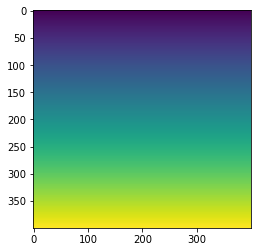

In [91]:
plt.figure()
plt.imshow(vp.T)
plt.show()

Plot the wavelet

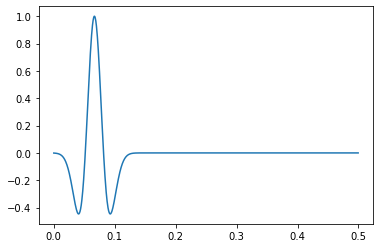

In [92]:
plt.figure()
plt.plot(time,wav)
plt.show()

A function to generate absorbing mask:

In [93]:
def gen_absorb(nx,nz,nabs,a,FreeSurf=False):
    absorb = np.ones((nx,nz))
    abs_coefs = np.zeros(nabs)
    abs_coefs = np.exp(-(a**2 * (nabs-np.arange(nabs))**2))
    absorb[:nabs,:] = absorb[:nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-nabs:,:] = absorb[-nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-nabs:] = absorb[:,-nabs:]*abs_coefs[::-1]
    if(FreeSurf==False):
        absorb[:,:nabs] = absorb[:,:nabs]*abs_coefs
    return absorb

A function to compute second-order derivatives for FD scheme

In [94]:
def comp_deriv(p,dd):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(dd**2)
    return pdx2, pdz2

Main function

In [95]:
def fd_ac(vp,dd,dt,srcx,srcz,wav,nabs=40,a=0.0053,FreeSurf=False):
    srci = int(srcx/dd) # find where source is located on the grid
    srcj = int(srcz/dd)
    nx,nz = vp.shape # infer shapes
    nt = wav.shape[0]

    field2d = np.zeros((nx,nz,nt),dtype=np.float) # define variables  - field2d is output wavefield
    p = np.zeros((nx,nz),dtype=np.float) # these are pressures at current, prev and next steps
    ppast = np.zeros((nx,nz),dtype=np.float)
    pfut = np.zeros((nx,nz),dtype=np.float)
    
    vp2 = vp**2 # square of velocity for easier computation
    absorb = gen_absorb(nx,nz,nabs,a,FreeSurf=FreeSurf) # generate absorbing mask
    
    for i in tqdm(range(nt)): # main loop
        pdx2, pdz2 = comp_deriv(p,dd) # compute pressure derivatives
        pfut = 2 * p + vp2 * dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 
        pfut[srci,srcj] = pfut[srci,srcj] + wav[i] / (dd * dd) * dt ** 2 # inject source term at selected point
        
        p *= absorb # apply absorbing mask
        pfut *= absorb # apply absorbing mask

        field2d[:,:,i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut
    return field2d

Plotting the wavefield at two points in time

In [102]:
SIZE = 20  # 20 симуляций
x_mas = np.random.randint(0, nx-1, SIZE)
z_mas = np.random.randint(0, nz-1, SIZE)

k = 0
with h5py.File('data.hdf5', 'w') as f:
    for srcx, srcz in tqdm(zip(x_mas, z_mas)):
        wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf)
        f.create_dataset(f'{k}_sim', data=wvfld)
        f.create_dataset(f'{k}_sim_source', data=np.array([srcx, srcz]))
        k+=1
                         
    f.create_dataset(f'vp', data=vp)    
    f.create_dataset(f'params', data=np.array([dd,dt,srcx,srcz]))
    f.create_dataset(f'wav', data=wav)
    f.create_dataset(f'params_2', data=np.array([nabs, a, 0 if FreeSurf==False else 1]))

In [112]:
with h5py.File('data.hdf5', 'r') as f:  # чтение из файла
    for i in range(SIZE):
        name = f'{i}_sim'
        simulation =  f[name][:]
        srcx, srcz = f[name + '_source']

0


KeyboardInterrupt: 

173

### В разработке

In [ ]:
SIZE = 8
B_SIZE = 4
x_mas = np.random.randint(0, nx-1, SIZE)
z_mas = np.random.randint(0, nz-1, SIZE)

In [ ]:
data = np.zeros((B_SIZE, nx, nz, nt))

In [ ]:
data.shape

In [ ]:
k = 0
with h5py.File('random.hdf5', 'w') as f:
    for srcx, srcz in tqdm(zip(x_mas, z_mas)):
        wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf)[np.newaxis, :, :, :]
        i = k % 4
        data[i] = wvfld[0]
        if  i == 3:
            f.create_dataset(f'batch_{int(k / 4)}', data=wvfld)
            del(data)
            del(wvfld)
            data = np.zeros((4, 400, 400, 100))
        k+=1

